<br>

# Running ev-MOGA alogorithm for sustainable portfolio selection

3 objectives

<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import savemat

# import time
# import os

In [2]:
import evmoga as ev
from evmoga import portfolio_selection_user_functions as uf
from evmoga import utilities as evu

ev-MOGA package initialized.


## Import data to define the optimization problem

Description and other information about the data:

In [3]:
dataset = "Eurostoxx50"
# dataset = "DowJones"
# dataset = "FTSE100"
# dataset = "NASDAQ100"
# dataset = "SP500"

excel_input_data = "./Datasets/Datasets_Sustainability/" + dataset + ".xlsx"

price_sheet_name = "AssetPrices"
esg_sheet_name = "ESG"

Nind_P = int(10000) # Main population size
Generations = int(1000) # Number of generations
N_div = int(200) # Number of divisions per objective
Nind_GA = int(200) # Auxiliary population size (mutation + crossover)
Nit = int(100) # Number of iterations for storing time evolution data (Nind_A, spent time)

# UB = 0.20  # Upper Bound for actives in portfolio
# LB = 0.01  # Lower Bound for actives in portfolio
UB = 1.00  # Upper Bound for actives in portfolio
LB = 0.00  # Lower Bound for actives in portfolio

v31 = 0 # v31 \in {0, 25000, 37500, 50000, 100000}
v13 =  2.0e-05 # v13 \in {8.0e-06, 1.4e-05, 2.0e-05, 3.0e-05}
v21 = 0

suffix = "" # For the file name
# suffix = "_Ndiv_100" 
# suffix = "_a_priori" 
# suffix = "_UB_01"
# suffix = "_UB_02"

description = 'Mean - Variance - ESG Score (3 objectives) - ' + dataset
objectives = ["Mean Return", "Variance", "ESG Score"]
signs = [-1, +1, -1]

# Options:
save_results = True
mat_folder = "./mat_files/"
mat_filename = mat_folder + "evMOGApy_" + dataset + suffix + "_3obj.mat" 

Daily and mean returns:

In [4]:
df = pd.read_excel(excel_input_data, sheet_name=price_sheet_name,
                index_col=0, header=None).dropna(axis=1)
df = df.pct_change(axis=0).dropna(axis=0)
# display(df)

returns = df.values.T
mean_r = returns.mean(axis=1)
cov_Mtrx = np.cov(returns)

print(f"Returns shape = {returns.shape}")
print(f"Mean returns shape = {mean_r.shape}")
print(f"Shape of Covariance matrix = {cov_Mtrx.shape}")

Returns shape = (45, 3714)
Mean returns shape = (45,)
Shape of Covariance matrix = (45, 45)


ESG score

In [5]:
df = pd.read_excel(excel_input_data, sheet_name=esg_sheet_name, 
                index_col=0, header=None).dropna(axis=1)
esg = df.iloc[1:, :].values.mean(axis=0)

print(f"ESG Shape = {esg.shape}")
# display(esg)

ESG Shape = (45,)


## Setting-up and running ev-MOGA

In [6]:
n_obj = len(signs) # Number of objectives
n_var = mean_r.shape[0] # Number of decision variables

eMOGA = {
    
    'description': description,
    'objectives': objectives,

    'objfun': uf.objective_function_3obj,
    'iterationfun': uf.fun_iteration,
    'resultsfun': uf.fun_results,
    'constraintfun': uf.sum1,

    'objfun_dim': n_obj,
    'searchSpace_dim': n_var,
    'searchspaceUB': UB * np.ones(n_var),
    'searchspaceLB': LB * np.ones(n_var),

    'Nind_P': Nind_P,
    'Generations': Generations,

    'Nind_GA': Nind_GA,
    'n_div': [N_div for i in range(n_obj)],

    'param': {
        'signs': signs,
        'esg': esg,
        'ret': returns,
        'mean_r': mean_r,
        'cov_Mtrx': cov_Mtrx,
        },

    'Sigma_Pm_ini': 20,
    'Sigma_Pm_fin': 0.1,

    'Pm': 0.5,
    'randseed': 12345,

    # ------------------------------
    # User-defined:

    'precision_onoff': True,
    'precision': 0.001,

    'save_results': save_results,
    'mat_file': mat_filename,

    'Nit': Nit
}

if suffix == "_a_priori":

    v1 = np.matrix([1, 0, v13]).T  # Mean return
    v2 = np.matrix([v21, 1, 0]).T  # Variance
    v3 = np.matrix([v31, 0, 1]).T  # ESG risk

    Mp = np.matrix(np.hstack((v1, v2, v3))) # It is required to be a matrix
    Md = evu.dominanceCone(Mp)
    eMOGA['param']['Md'] = Md
    eMOGA['param']['Md_1'] = np.linalg.inv(Md)

    print(f"Matrix of preference directions Mp = \n{Mp}\n")
    print(f"Matrix of directions of the edges of the dominance cones Md = \n{eMOGA['param']['Md']}\n")
    print(f"Matrix of directions of the edges of the dominance cones Md_1 = \n{eMOGA['param']['Md_1']}\n")


eMOGA = uf.generate_P0(eMOGA)

eMOGA = ev.MOGA(eMOGA)


--------------------------------------------------------

Generating user-defined initial population P(0) with 10000 individuals



100%|██████████| 10000/10000 [00:04<00:00, 2015.36it/s]



--------------------------------------------------------

Initializing ev-MOGA algorithm...

Initial population P(0) with 10000 individuals found
No new solutions needed

Estimating value functions of P(0)

Estimating the initial e-Pareto front A(0):
      - Marking non-dominated solutions...
      - Selecting epsilon-non-dominated solutions...


	100%|██████████|



Iterating process searching for e-Pareto front...

Generations: 0 out of 1000. Nind_A = 194 (elapsed time: 0.3 s)
Generations: 100 out of 1000. Nind_A = 854 (elapsed time: 19.1 s)
Generations: 200 out of 1000. Nind_A = 1288 (elapsed time: 36.3 s)
Generations: 300 out of 1000. Nind_A = 2120 (elapsed time: 38.2 s)
Generations: 400 out of 1000. Nind_A = 2280 (elapsed time: 62.7 s)
Generations: 500 out of 1000. Nind_A = 1975 (elapsed time: 74.3 s)
Generations: 600 out of 1000. Nind_A = 2756 (elapsed time: 58.9 s)
Generations: 700 out of 1000. Nind_A = 2666 (elapsed time: 55.8 s)
Generations: 800 out of 1000. Nind_A = 2248 (elapsed time: 69.5 s)
Generations: 900 out of 1000. Nind_A = 2799 (elapsed time: 90.8 s)
Generations: 1000 out of 1000. Nind_A = 2890 (elapsed time: 96.6 s)


## Plotting results

In [7]:
if 'Md' in eMOGA['param']:
    # Md = np.matrix(eMOGA['param']['Md']) # Equivalent
    # pfront = np.matrix(eMOGA['coste_A'])
    # pfront = np.transpose(Md * pfront.T)
    # # display(Md, Md.shape)
    # # display(pfront.T, pfront.T.shape)
    # # display(pfront, pfront.shape)

    Md = eMOGA['param']['Md']
    pfront = eMOGA['coste_A'].copy()
    pfront = np.transpose(np.matmul(Md, pfront.T))
    # display(pfront, pfront.shape)
    
    eMOGA['coste_A_optimization'] = eMOGA['coste_A'].copy()
    eMOGA['coste_A'] = pfront.copy()
    # display(eMOGA['coste_A'], eMOGA['coste_A'].shape)

(<Figure size 1275x467.5 with 3 Axes>,
 array([<Axes: xlabel='Mean Return', ylabel='Normalized distance'>,
        <Axes: xlabel='Variance'>, <Axes: xlabel='ESG Score'>],
       dtype=object))

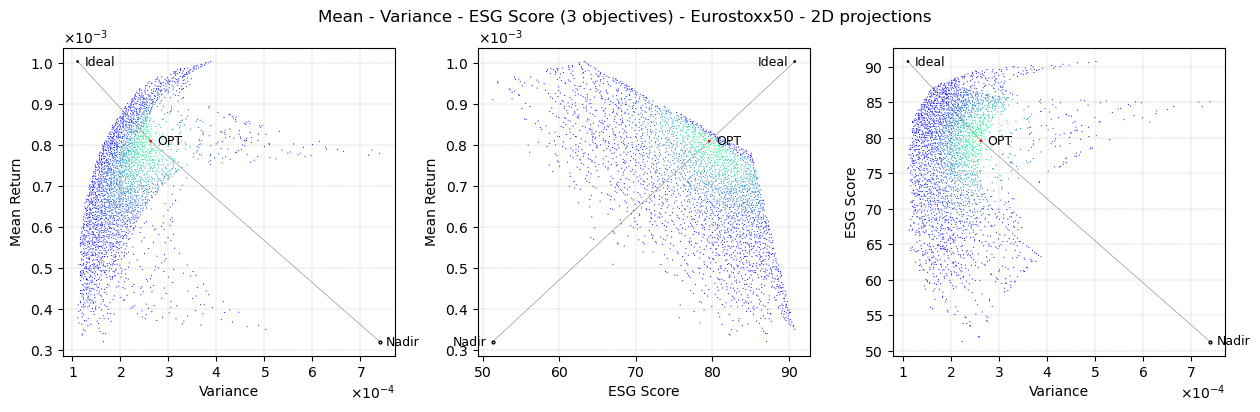

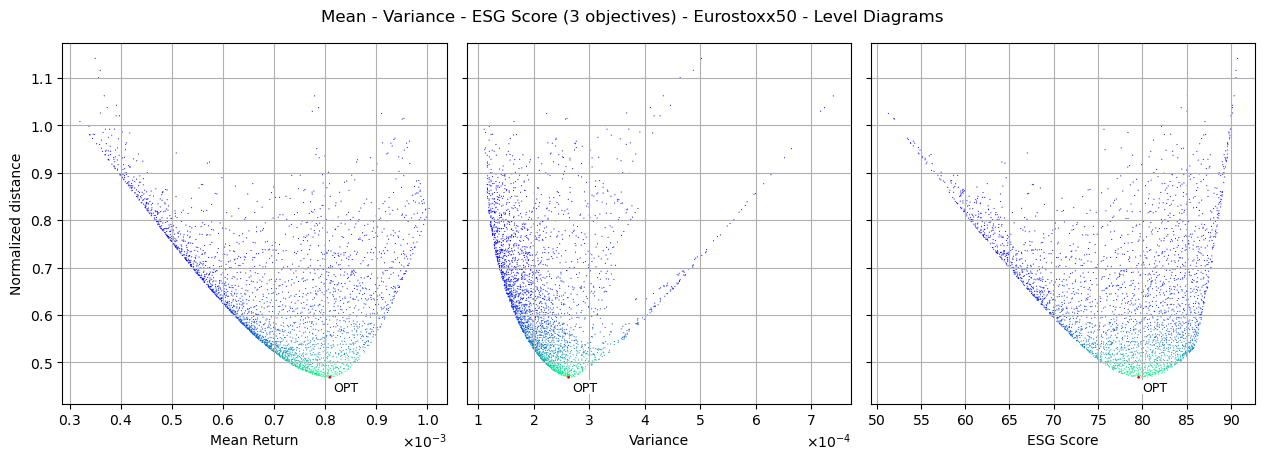

In [8]:
dot_size_3D = 1.0
opt_dot_size_factor_3D = 3

dot_size_2D = 2.5
opt_dot_size_factor_2D = 8

eMOGA['signs'] = np.array(eMOGA['param']['signs'])
cmap = 'winter'

if 'graph options' not in eMOGA:
    eMOGA['graph options'] = dict()
eMOGA['graph options']['dot_size_2D'] = dot_size_2D
eMOGA['graph options']['obj_ord_3D'] = [1, 2, 0]
eMOGA['graph options']['dot_size_3D'] = dot_size_3D
eMOGA['graph options']['opt_dot_size_factor_3D'] = opt_dot_size_factor_3D
eMOGA['graph options']['3D_view'] = {
    'azimuth': -135,
    'elevation': 20,
    'distance': 2.5,
}

evu.plot_Pareto_Front(eMOGA, plot_optims=True)
evu.plot_2D_projections(eMOGA)
evu.plot_Level_Diagrams(eMOGA, plot_params_LD=False)

## Saving additional information to eMOGA structure

In [9]:
if eMOGA['save_results']:
    savemat(eMOGA['mat_file'], eMOGA)

## Exploring results

Optimum:

In [10]:
k = [i for i in range(len(eMOGA['profiles'])) if eMOGA['profiles'][i]['Name'] == 'Optimum']
if k:
	print(f"Optimum:\n")
	j = [i for i in range(len(eMOGA['profiles'][k[0]]['x'])) if eMOGA['profiles'][k[0]]['x'][i] > 0]
	for i in j:
		print(f"x_{i} = {eMOGA['profiles'][k[0]]['x'][i]:.3f} ({df.index[i]})")
	print(f"\nz = {(eMOGA['profiles'][k[0]]['z'])}")
else:
	print("No 'Optimum' profile found")

Optimum:

x_1 = 0.272 (2006-10-09 00:00:00)
x_18 = 0.117 (2006-11-01 00:00:00)
x_30 = 0.001 (2006-11-17 00:00:00)
x_32 = 0.609 (2006-11-21 00:00:00)
x_38 = 0.001 (2006-11-29 00:00:00)

z = [8.09226830e-04 2.62974834e-04 7.95821064e+01]
